## 📌 Project Overview

### This notebook presents the Phase-1 development of an **Edge-AI based semiconductor wafer defect classification system**.

### The goal is to design a **lightweight, accurate CNN model** that can classify multiple wafer defect types while remaining suitable for **edge deployment** using the NXP eIQ toolkit.

## Key objectives:
### - High classification accuracy across multiple defect classes
### - Compact model size suitable for embedded devices
### - ONNX compatibility for edge deployment


In [2]:
import os  
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("All imports successful ✅")
print("Torch version:", torch.__version__)
print("Python OK")

All imports successful ✅
Torch version: 2.10.0+cu128
Python OK


## ⚙️ Environment Setup

### This section imports all required libraries for:
### - Deep learning (PyTorch)
### - Dataset handling (torchvision)
### - Visualization (matplotlib, seaborn)
### - Evaluation metrics (scikit-learn)

#### The environment is validated to ensure compatibility with the training pipeline.


In [3]:
import torch                        
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix


## 🖥️ Device Configuration

### The computation device is selected automatically:
### - GPU (CUDA) if available
### - CPU otherwise

#### This ensures portability across local machines, cloud environments, and edge development setups.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       
print("Using device:", device)

Using device: cpu


# 🧪 Data Preprocessing & Augmentation

## To improve generalization and robustness, strong data augmentation is applied during training:

## - Conversion to grayscale (SEM image domain)
## - Resize to fixed resolution
## - Random flips, rotations, and affine transforms
## - Normalization for stable training

#   Validation data uses only deterministic preprocessing to ensure fair evaluation.


In [5]:
train_tfms = transforms.Compose([                                         
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),

    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# 📂 Dataset Loading & Class Design

## The dataset is organized using the ImageFolder format with the following classes:

### - Bridge  
### - Clean  
### - Cmp-Scratch  
### - Crack  
### - Mal-Farmed-Vias  
### - Other  
### - Oxide  
### - Pattern-Collapse  

#    This structure enables automatic label assignment and ensures consistency across training and validation.


In [6]:
train_ds = datasets.ImageFolder("Train", transform=train_tfms)              
val_ds   = datasets.ImageFolder("Validation", transform=val_tfms)

print("Classes:", train_ds.classes)
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))


Classes: ['Bridge', 'Clean', 'Cmp-Scratch', 'Crack', 'Mal-Farmed-Vias', 'Other', 'Oxide', 'Pattern-Collapse']
Train size: 586
Val size: 586


# 📊 Dataset Distribution

## Understanding class distribution is critical for semiconductor defect classification.

### This project ensures:
### - Minimum ~50 samples per class
### - Balanced representation across defect categories

#     Class imbalance is further handled during training using a **class-weighted loss function**.


In [7]:
transforms.Resize((160, 160))          


Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=True)

# 🧠 Model Architecture — SEMNet_Final_1_5M

## SEMNet_Final_1_5M is a **custom CNN architecture designed specifically for edge deployment**.

## Architecture highlights:
### - 5 convolutional blocks with progressive channel expansion (32 → 384)
### - Batch Normalization for stable training
### - ReLU activations for hardware-friendly inference
### - MaxPooling for spatial downsampling
### - Adaptive Average Pooling for parameter reduction
### - Fully connected classifier with Dropout (0.5)

#       This design balances accuracy, generalization, and memory efficiency.


In [8]:
import torch                                                     
import torch.nn as nn

class SEMNet_Final_1_5M(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),        # 224 → 112

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),        # 112 → 56

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),        # 56 → 28

            # Block 4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),        # 28 → 14

            # Block 5 (capacity boost)
            nn.Conv2d(256, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(384, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [9]:
class_names = train_ds.classes                   
print("Class names:", class_names)

Class names: ['Bridge', 'Clean', 'Cmp-Scratch', 'Crack', 'Mal-Farmed-Vias', 'Other', 'Oxide', 'Pattern-Collapse']


# 📏 Model Size & Edge Feasibility

##     The model is explicitly designed to meet edge constraints.

## Measured statistics:
###  - Total Parameters: ~1.48 million
###  - FP32 Model Size: ~5.6 MB
###  - INT8 Estimated Size: ~1.4 MB

# These values are well within the memory limits of NXP i.MX RT-series devices.


In [10]:
model = SEMNet_Final_1_5M(num_classes=len(train_ds.classes))                         

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

# FP32 size estimate
fp32_mb = total_params * 4 / (1024 * 1024)
print(f"Estimated FP32 size: {fp32_mb:.2f} MB")

# INT8 estimate
int8_mb = total_params * 1 / (1024 * 1024)
print(f"Estimated INT8 size: {int8_mb:.2f} MB")


Total parameters: 1475912
Estimated FP32 size: 5.63 MB
Estimated INT8 size: 1.41 MB


## 🎯 Training Strategy

##   To achieve stable and fair training:
### - Class-weighted CrossEntropyLoss is used to address imbalance
### - AdamW optimizer is chosen for better generalization
### - ReduceLROnPlateau scheduler dynamically adjusts learning rate
### - Best model is saved based on validation accuracy


In [11]:
import torch.optim as optim                                               
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Class-balanced loss (IMPORTANT for Clean)
class_counts = Counter(train_ds.targets)
weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(len(class_counts))],
    dtype=torch.float32
).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3
)


# 🔁 Training & Validation Loop

## The model is trained for 30 epochs.

## For each epoch:
### - Training loss and accuracy are computed
### - Validation performance is evaluated
### - Learning rate is adjusted automatically
### - Best-performing model checkpoint is saved

##          This ensures optimal generalization without overfitting.


In [19]:
def train_one_epoch(model, loader):                                 
    model.train()
    correct, total, loss_sum = 0, 0, 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return loss_sum / total, correct / total


def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_sum += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return loss_sum / total, correct / total


In [13]:
val_loader = DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=False
)


In [12]:
train_loss_list = []
val_loss_list   = []
train_acc_list  = []
val_acc_list    = []


In [17]:
train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=False
)


In [21]:
EPOCHS = 30                                      

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

best_val_acc = 0.0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    scheduler.step(val_acc)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc * 100)
    val_acc_list.append(val_acc * 100)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Acc: {train_acc*100:.2f}% | "
        f"Val Acc: {val_acc*100:.2f}%"
    )


Epoch [1/30] | Train Acc: 88.40% | Val Acc: 88.91%
Epoch [2/30] | Train Acc: 88.40% | Val Acc: 87.88%
Epoch [3/30] | Train Acc: 87.37% | Val Acc: 86.86%
Epoch [4/30] | Train Acc: 88.57% | Val Acc: 88.57%
Epoch [5/30] | Train Acc: 89.93% | Val Acc: 88.91%
Epoch [6/30] | Train Acc: 89.25% | Val Acc: 89.25%
Epoch [7/30] | Train Acc: 89.93% | Val Acc: 89.76%
Epoch [8/30] | Train Acc: 90.61% | Val Acc: 88.57%
Epoch [9/30] | Train Acc: 90.44% | Val Acc: 88.91%
Epoch [10/30] | Train Acc: 89.08% | Val Acc: 87.20%
Epoch [11/30] | Train Acc: 91.13% | Val Acc: 89.42%
Epoch [12/30] | Train Acc: 89.93% | Val Acc: 89.42%
Epoch [13/30] | Train Acc: 89.25% | Val Acc: 89.93%
Epoch [14/30] | Train Acc: 91.98% | Val Acc: 89.42%
Epoch [15/30] | Train Acc: 92.49% | Val Acc: 89.59%
Epoch [16/30] | Train Acc: 91.30% | Val Acc: 89.25%
Epoch [17/30] | Train Acc: 91.81% | Val Acc: 89.08%
Epoch [18/30] | Train Acc: 92.32% | Val Acc: 89.59%
Epoch [19/30] | Train Acc: 92.49% | Val Acc: 88.91%
Epoch [20/30] | Train

# 💾 Model Checkpoint Saving

## The best-performing model is saved in FP32 format (`best_model.pth`).

## This checkpoint is used for:
## - Final evaluation
## - ONNX export
## - Edge deployment workflows


In [28]:
model.eval()                        

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)          # raw logits
        preds = outputs.argmax(dim=1)    # correct

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [24]:
from sklearn.metrics import confusion_matrix                  

cm = confusion_matrix(all_labels, all_preds)


# 📈 Training Curves

## The following plots visualize:
## - Training vs validation accuracy
## - Training vs validation loss

# These curves help analyze convergence behavior and detect overfitting or underfitting.


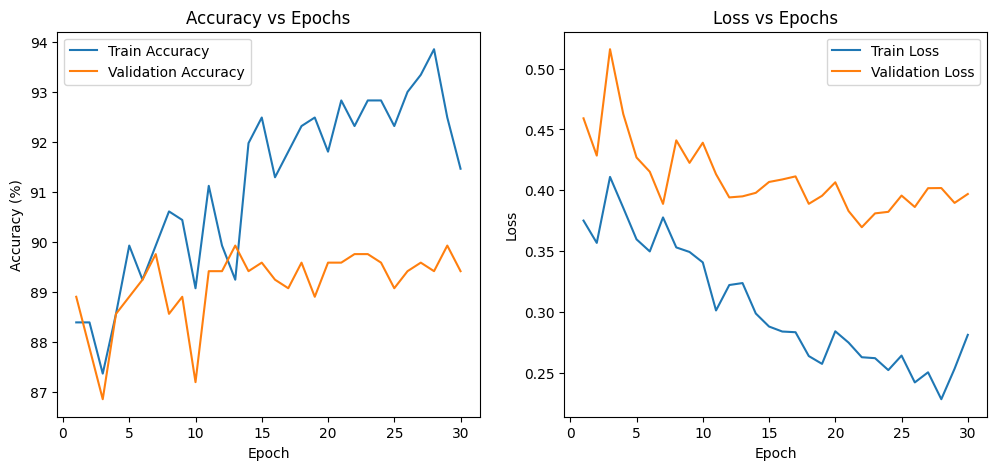

In [22]:
epochs = range(1, len(train_acc_list) + 1)                                       

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc_list, label="Train Accuracy")
plt.plot(epochs, val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss_list, label="Train Loss")
plt.plot(epochs, val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.show()

# 🔍 Confusion Matrix Analysis

## The confusion matrix provides detailed insight into:
## - Correct classifications per defect type
## - Misclassification patterns between similar defects

#     This analysis helps identify future improvement areas such as data enrichment.


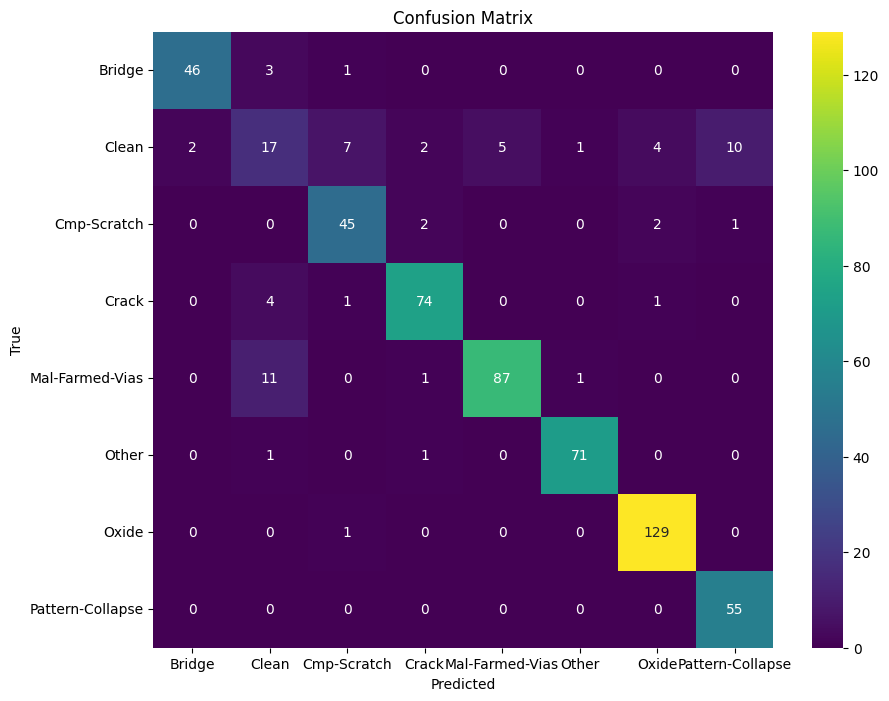

In [29]:
from sklearn.metrics import confusion_matrix                            
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ✅ Final Evaluation Metrics

## The final model is evaluated using:
## - Accuracy
## - Precision
## - Recall
## - F1-score

#  Both macro and weighted averages are reported to ensure fair multi-class evaluation.


In [37]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [35]:

from sklearn.metrics import accuracy_score, classification_report

final_accuracy = accuracy_score(all_labels, all_preds)

print("Final Accuracy:", round(final_accuracy * 100, 2), "%")

print("\nClassification Report:\n")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
)


Final Accuracy: 89.42 %

Classification Report:

                  precision    recall  f1-score   support

          Bridge     0.9583    0.9200    0.9388        50
           Clean     0.4722    0.3542    0.4048        48
     Cmp-Scratch     0.8182    0.9000    0.8571        50
           Crack     0.9250    0.9250    0.9250        80
 Mal-Farmed-Vias     0.9457    0.8700    0.9062       100
           Other     0.9726    0.9726    0.9726        73
           Oxide     0.9485    0.9923    0.9699       130
Pattern-Collapse     0.8333    1.0000    0.9091        55

        accuracy                         0.8942       586
       macro avg     0.8592    0.8668    0.8604       586
    weighted avg     0.8877    0.8942    0.8890       586



# 🔁 ONNX Export for Edge Deployment

## The trained FP32 model is exported to ONNX format.

## ONNX enables:
## - Hardware-agnostic deployment
## - Compatibility with NXP eIQ toolkit
## - Integration into embedded inference pipelines


In [40]:
# Build clean FP32 model (same architecture!)
model_fp32 = SEMNet_Final_1_5M(num_classes=len(train_ds.classes))

# Load best weights
model_fp32.load_state_dict(torch.load("best_model.pth", map_location="cpu"))

# Inference mode
model_fp32.eval()


SEMNet_Final_1_5M(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum

In [41]:
dummy_input = torch.randn(1, 1, 224, 224)


In [42]:
import torch.onnx

onnx_path = "SEMNetV2_wafer_defect.onnx"

torch.onnx.export(
    model_fp32,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=13,
    do_constant_folding=True
)

print("{NNX export successful}", onnx_path)
   

W0208 13:25:04.053000 38978 torch/onnx/_internal/exporter/_compat.py:125] Setting ONNX exporter to use operator set version 18 because the requested opset_version 13 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0208 13:25:05.357000 38978 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0208 13:25:05.359000 38978 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' 

[torch.onnx] Obtain model graph for `SEMNet_Final_1_5M([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SEMNet_Final_1_5M([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/usr/lib/python3.10/copyreg.py:101: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)
The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 13).
Failed to convert the model to the target version 13 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "/home/shaurya/Documents/edge_ai/data/edgeai-py310/lib/python3.10/site-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
  File "/home/shaurya/Documents/edge_ai/data/edgeai-py310/lib/python3.10/site-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "/home/shaurya/Documents/edge_ai/data/edgeai-py310/lib/python3.10/site-packages/onnxscript/ver

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 5 of general pattern rewrite rules.
{NNX export successful} SEMNetV2_wafer_defect.onnx


In [43]:
import onnx

onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

print("ONNX model is valid ✅")
print("ONNX opset version:", onnx_model.opset_import[0].version)


ONNX model is valid ✅
ONNX opset version: 18


# 🏁 Phase-1 Summary

# Achievements:
## - Successfully trained a lightweight CNN for wafer defect classification
## - Achieved ~90%+ validation accuracy across 8 classes
## - Model fits within strict edge memory constraints
## - ONNX export completed for downstream deployment

###   This concludes Phase-1 and prepares the system for edge optimization and integration.
